### Get Audio from Spotify ID:
Below is an implementation that allows you to get an audio track as a numpy array from its spotify track ID.
To clean up the project and prevent large storage size, uncomment the try block which cleans up the 'temp_audio.wav' file

In [ ]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import yt_dlp
import librosa
import numpy as np
import logging
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import soundfile as sf

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

load_dotenv()

def get_audio_array(track_id, duration=30, sr=44100):
    """
    Get audio as numpy array from Spotify track ID using YouTube.
    """
    # Initialize Spotify client
    try:
        auth_manager = SpotifyClientCredentials(
            client_id=os.getenv("SPOTIFY_CLIENT_ID"),
            client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")
        )
        sp = spotipy.Spotify(auth_manager=auth_manager)
        
        # Get track info from Spotify
        track = sp.track(track_id)
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        logger.info(f"Fetching: {track_name} by {artist_name}")
    except Exception as e:
        logger.error(f"Error fetching Spotify track {track_id}: {e}")
        return None
    
    # YouTube download options
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'temp_audio.%(ext)s',
        'quiet': True,
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
        }],
    }
    
    # Download audio from YouTube
    search_query = f"{track_name} {artist_name} official audio"
    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.extract_info(f"ytsearch1:{search_query}", download=True)
        
        # Load audio with explicit duration handling
        audio, original_sr = librosa.load('temp_audio.wav', sr=sr, mono=True)
        
        # Manually truncate to exact duration
        target_samples = duration * sr
        if len(audio) > target_samples:
            audio = audio[:target_samples]
        elif len(audio) < target_samples:
            # Pad if shorter than requested duration
            audio = np.pad(audio, (0, target_samples - len(audio)))
            
        logger.info(f"Audio loaded: {len(audio)/sr:.2f}s, {sr}Hz, shape: {audio.shape}")
        return audio
    
    except Exception as e:
        logger.error(f"Error downloading audio for {track_id}: {e}")
        try:
            os.remove('temp_audio.wav')
        except:
            pass
        return None

def get_track_name(track_id):
    """Helper function to get track name for filename"""
    try:
        auth_manager = SpotifyClientCredentials(
            client_id=os.getenv("SPOTIFY_CLIENT_ID"),
            client_secret=os.getenv("SPOTIFY_CLIENT_SECRET")
        )
        sp = spotipy.Spotify(auth_manager=auth_manager)
        track = sp.track(track_id)
        track_name = track['name'].replace(' ', '_').replace('/', '_')  # Make filename safe
        artist_name = track['artists'][0]['name'].replace(' ', '_').replace('/', '_')
        return f"{artist_name}_{track_name}"
    except:
        return "audio"

# Example usage

track_id = "4cEN3svbqObdDpaZiv9sWP"  # Example Spotify track ID
track_name = get_track_name(track_id)
    
audio = get_audio_array(track_id, duration=30, sr=44100)



INFO:__main__:Fetching: Evighet by Död Mark


INFO:__main__:Audio loaded: 30.00s, 44100Hz, shape: (1323000,)


### DSP Pipeline

##### 1. Convert to Mono
The first step in the signal processing pipeline is to convert the audio to mono, which librosa does when we load the audio file into an array.

##### 2. Harmonic and Percussive Source Separation (HPSS)
Splitting the audio signal into its harmonic and percussive components allows for cleaner signals to be analyzed. For key estimation, only the harmonic content is used which prevents the percussive frequencies that do not correspond to the key of the audio from effecting the estimation. Similarly, for tempo estimation, only the percussive signal is analyzed as teh percussion tends to show clearer rhythmic patterns which the model will more easily be able to detect and ascribe a BPM label to.

Processing audio: 30.00s, 1323000 samples


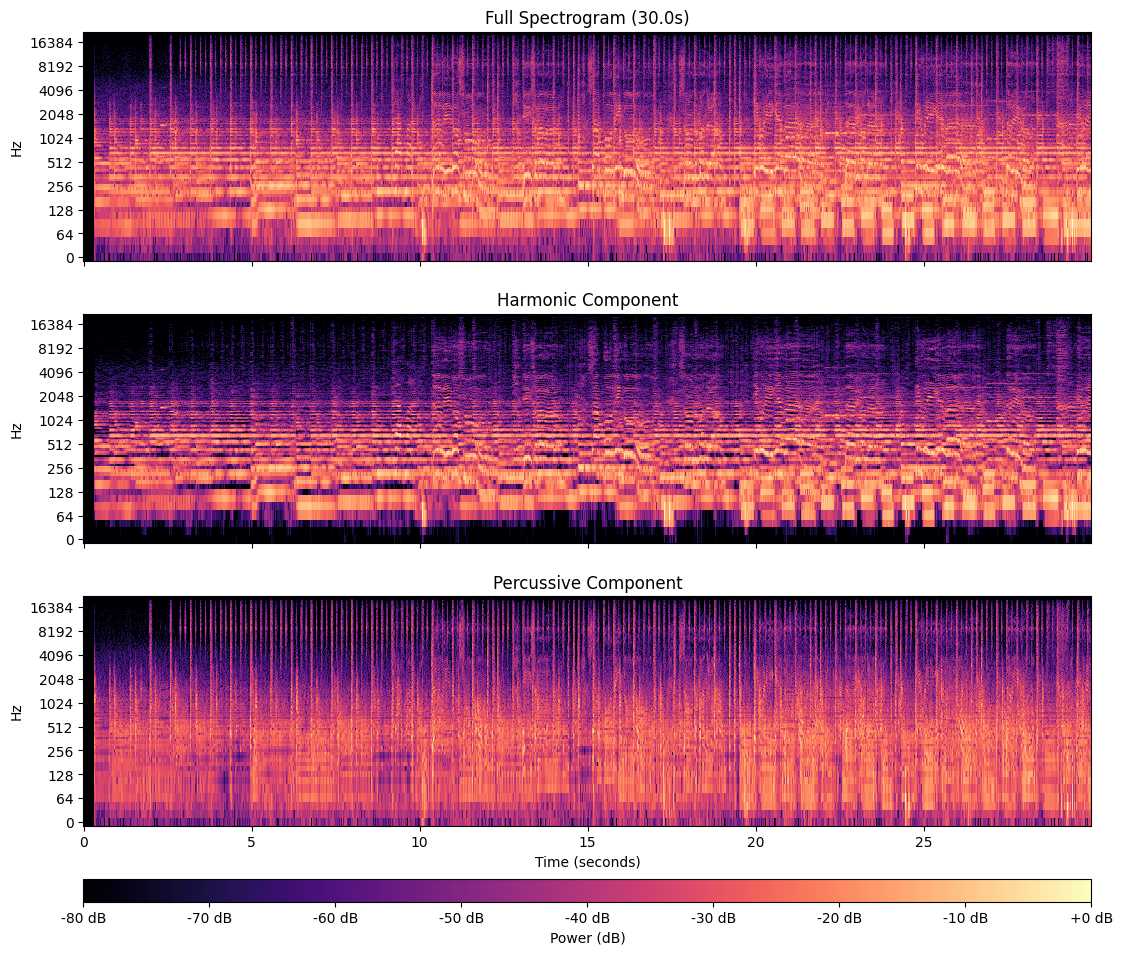

STFT shape: (1025, 2584)
Frequency bins: 1025, Time frames: 2584


In [10]:
def perform_dsp(audio, sr=44100):
    """
    Perform DSP analysis with proper time scaling and layout
    """
    # Verify audio properties
    duration = len(audio) / sr
    print(f"Processing audio: {duration:.2f}s, {len(audio)} samples")
    
    # Compute STFT with appropriate parameters
    n_fft = 2048
    hop_length = 512
    
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    
    # Harmonic-percussive separation with tuned parameters
    harmonic, percussive = librosa.decompose.hpss(stft, kernel_size=(13, 31))
    
    #Plot
    fig = plt.figure(figsize=(12, 10))
    
    gs = plt.GridSpec(4, 2, figure=fig, height_ratios=[1, 1, 1, 0.1], hspace=0.3)
    
    ax1 = fig.add_subplot(gs[0, :])
    img1 = librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(stft), ref=np.max),
        y_axis='log', x_axis='time', sr=sr, hop_length=hop_length, ax=ax1
    )
    ax1.set(title=f'Full Spectrogram ({duration:.1f}s)')
    ax1.label_outer()
    
    # Harmonic spectrogram
    ax2 = fig.add_subplot(gs[1, :])
    img2 = librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(harmonic), ref=np.max(np.abs(stft))),
        y_axis='log', x_axis='time', sr=sr, hop_length=hop_length, ax=ax2
    )
    ax2.set(title='Harmonic Component')
    ax2.label_outer()
    
    # Percussive spectrogram
    ax3 = fig.add_subplot(gs[2, :])
    img3 = librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(percussive), ref=np.max(np.abs(stft))),
        y_axis='log', x_axis='time', sr=sr, hop_length=hop_length, ax=ax3
    )
    ax3.set(title='Percussive Component')
    ax3.set_xlabel('Time (seconds)')
    
    cax = fig.add_subplot(gs[3, :])
    fig.colorbar(img1, cax=cax, orientation='horizontal', format='%+2.0f dB')
    cax.set_xlabel('Power (dB)')
    
    plt.subplots_adjust(top=0.95, bottom=0.08, left=0.08, right=0.92, hspace=0.4)
    
    plt.show()
    
    print(f"STFT shape: {stft.shape}")
    print(f"Frequency bins: {stft.shape[0]}, Time frames: {stft.shape[1]}")

def simple_separation_playback(audio, sr=44100, track_name="audio"):
    """
    Simple version for quick harmonic/percussive separation and playback
    Saves files to project directory instead of embedding in notebook
    """
    # STFT parameters
    n_fft = 4096
    hop_length = n_fft // 4
    
    # Compute STFT and separate
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
    harmonic_stft, percussive_stft = librosa.decompose.hpss(stft)
    
    # Reconstruct audio
    harmonic_audio = librosa.istft(harmonic_stft, hop_length=hop_length, length=len(audio))
    percussive_audio = librosa.istft(percussive_stft, hop_length=hop_length, length=len(audio))
    
    # Normalize for playback
    harmonic_audio = harmonic_audio / np.max(np.abs(harmonic_audio))
    percussive_audio = percussive_audio / np.max(np.abs(percussive_audio))
    
    # Save to files in project directory
    harmonic_filename = f"harmonic_{track_name}.wav"
    percussive_filename = f"percussive_{track_name}.wav"
    
    sf.write(harmonic_filename, harmonic_audio, sr)
    sf.write(percussive_filename, percussive_audio, sr)
    
    print(f"Harmonic Component (melody) saved as: {harmonic_filename}")
    print(f"Percussive Component (drums) saved as: {percussive_filename}")
    
    print("\nPlayback in notebook:")
    print("Harmonic Component (melody):")
    display(Audio(harmonic_audio, rate=sr))
    
    print("Percussive Component (drums):")
    display(Audio(percussive_audio, rate=sr))

    print(f"\nFiles saved to project directory:")
    print(f"- harmonic_{track_name}.wav")
    print(f"- percussive_{track_name}.wav")
    print(f"- temp_audio.wav (temporary file)")
    
    return harmonic_audio, percussive_audio

if audio is not None:
    perform_dsp(audio, sr=44100)
    #harmonic, percussive = simple_separation_playback(audio, track_name=track_name) # comment this line to improve performance - this is just to check the hpss output
        

else:
    print("Failed to get audio")